# Exploratory Data Analysis in pySpark II 

In [6]:
# set up 
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import *

sc = SparkContext(master = "local" \
                , appName = "Exploratory Data Analysis") 

# Create a spark session 
spark = SparkSession(sc)
sqlContext = SQLContext(spark)

In [24]:
# Files we will be working with
path = "/home/danae/Documents/pySparkTraining/files/"

df = spark.read.parquet(path + "olimpic_medals.parquet")
df.show(5)

+--------------------+------+---+------+------+-----+-------------+----+--------+-----------+
|                name|gender|age|height|weigth|medal|    name_game|year|  season|       city|
+--------------------+------+---+------+------+-----+-------------+----+--------+-----------+
|           A Dijiang|     1| 24|   180|  80.0|   NA|  1992 Verano|1992|  Verano|  Barcelona|
|            A Lamusi|     1| 23|   170|  60.0|   NA|  2012 Verano|2012|  Verano|     London|
| Gunnar Nielsen Aaby|     1| 24|     0|   0.0|   NA|  1920 Verano|1920|  Verano|  Antwerpen|
|Edgar Lindenau Aabye|     1| 34|     0|   0.0| Gold|  1900 Verano|1900|  Verano|      Paris|
|Christine Jacoba ...|     2| 21|   185|  82.0|   NA|1994 Invierno|1994|Invierno|Lillehammer|
+--------------------+------+---+------+------+-----+-------------+----+--------+-----------+
only showing top 5 rows



## Univariate Analysis

You have several options for visualizing and describing univariate data. Such as frequency Distribution Tables, bar Charts, histograms, frequency Polygons, pie Charts, etc.

In [8]:
num_cols = ['age','height', 'weigth']
df.select(num_cols).describe().show()

+-------+------------------+------------------+-----------------+
|summary|               age|            height|           weigth|
+-------+------------------+------------------+-----------------+
|  count|            134720|            134720|           134720|
|   mean|22.914251781472686|135.74386876484562|54.05841374708751|
| stddev| 7.129393603487543| 74.01294673589199|32.60358815741485|
|    min|                 0|                 0|              0.0|
|    max|                96|               223|            214.0|
+-------+------------------+------------------+-----------------+



You may find out that the default function in PySpark does not include the quartiles. The following function will help you to get the same results in Pandas

In [13]:
import numpy as np 
import pandas as pd 

def describe_pd(df_in, columns, deciles=False):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    :author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [14]:
describe_pd(df, num_cols)

,summary,age,height,weigth
0,count,134720,134720,134720
1,mean,22.914251781472686,135.74386876484562,54.05841374708751
2,stddev,7.129393603487543,74.01294673589199,32.60358815741485
3,min,0,0,0.0
4,max,96,223,214.0
5,25%,20,156,46
6,50%,23,171,64
7,75%,26,180,75


Sometimes, because of the confidential data issues, you can not deliver the real data and your clients may ask more statistical results, such as deciles. You can apply the follwing function to achieve it.

In [16]:
describe_pd(df, num_cols, deciles=True)

,summary,age,height,weigth
0,count,134720,134720,134720
1,mean,22.914251781472686,135.74386876484562,54.05841374708751
2,stddev,7.129393603487543,74.01294673589199,32.60358815741485
3,min,0,0,0.0
4,max,96,223,214.0
5,0%,0,0,0
6,10%,17,0,0
7,20%,19,0,0
8,30%,21,162,53
9,40%,22,168,60


## Skewness and Kurtosis

In [18]:
from pyspark.sql.functions import col, skewness, kurtosis
df.select(skewness('age'),kurtosis('age')).show()

+------------------+-----------------+
|     skewness(age)|    kurtosis(age)|
+------------------+-----------------+
|0.1488945385867726|6.348245689581315|
+------------------+-----------------+



## Frequency table

In [19]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
# withColumn('Percent %',F.format_string("%5.0f%%\n",col('Credit_num')*100/col('total'))).\
tab = df.select(['gender','weigth']).\
   groupBy('gender').\
   agg(F.count('weigth').alias('n'),
       F.mean('weigth').alias('avg'),
       F.min('weigth').alias('min'),
       F.max('weigth').alias('max')).\
   withColumn('total', sum(col('n')).over(window)).\
   withColumn('Percent',col('n')*100/col('total')).\
   drop(col('total'))

In [20]:
tab.show()

+------+-----+------------------+---+-----+------------------+
|gender|    n|               avg|min|  max|           Percent|
+------+-----+------------------+---+-----+------------------+
|     1|99026|54.255230949524666|0.0|214.0| 73.50504750593824|
|     2|35694| 53.51238303356306|0.0|167.0|26.494952494061756|
+------+-----+------------------+---+-----+------------------+



## Multivariate Analysis

### Correlation matrix

In [21]:
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_data = df.select(num_cols)

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

             age    height    weigth
age     1.000000  0.023890  0.052652
height  0.023890  1.000000  0.900309
weigth  0.052652  0.900309  1.000000


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

#df = sns.load_dataset("iris")
df_plot = df['age','height', 'weigth', 'gender']
df_plot.show(5)

+---+------+------+------+
|age|height|weigth|gender|
+---+------+------+------+
| 24|   180|  80.0|     1|
| 23|   170|  60.0|     1|
| 24|     0|   0.0|     1|
| 34|     0|   0.0|     1|
| 21|   185|  82.0|     2|
+---+------+------+------+
only showing top 5 rows



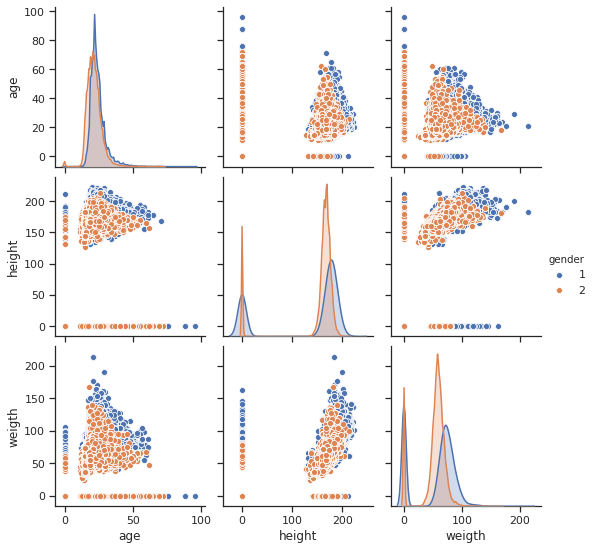

In [27]:
sns.pairplot(df_plot.toPandas(), hue = "gender")
plt.show()

### Cross table

In [30]:
df.stat.crosstab('season', 'gender').show()

+-------------+-----+-----+
|season_gender|    1|    2|
+-------------+-----+-----+
|       Verano|81995|28452|
|     Invierno|17031| 7242|
+-------------+-----+-----+



In [31]:
sc.stop() # close the spark session